# Preprocesamiento y EDA

Antes de seleccionar los modelos, se debe realizar un análisis de los datos con los que estamos trabajando. Así, se podrá elegir el mejor modelo para implementar.

El dataset con que estamos trabajando contiene señales EEG de sujetos de dos grupos, alcohólicos o controles. Se presentaron uno o dos estímulos (S1 o S1 y S2) en condiciones coincidentes (S1 = S2) o no coincidentes (S1 ̸= S2), con el objetivo de registrar la actividad cerebral mediante EEG durante el procesamiento visual y la toma de decisiones.

Sin embargo, la data se encuentra en un archivo .h5, que está diseñado para almacenar grandes cantidades de datos complejos. Por esta razón, no se puede trabajar de forma directa con el archivo.

Es por ello que se ha realizado un pipeline que extrae las caracteríticas más relevantes de nuestra base de datos (estamos trabajando con series de tiempo) y almacena dichos resultados en archivos .csv, que son más fáciles de manejar.

In [ ]:
# Se importan las librerías necesarias para el procesamiento de datos y la extracción de características (tsfresh)
import os
import h5py
import pandas as pd
import numpy as np
from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute
import matplotlib.pyplot as plt

Usaremos la librería h5py para abrir y leer archivos .h5:

In [9]:
train_file = "../train.h5"
test_file = "../test.h5"

with h5py.File(train_file, "r") as f:
    X_train = f["x"][:]   # señales EEG
    y_train = f["y"][:]   # etiquetas

with h5py.File(test_file, "r") as f:
    X_test = f["x"][:]    # señales EEG

# Exploración rápida
print(X_train.shape, X_train.dtype)
print(y_train.shape, y_train.dtype)
print(X_train[0,0,:5])  # primeras 5 muestras de EEG del primer sujeto
print(y_train[:5])       # primeras 5 etiquetas

(204, 1, 18530) float64
(204,) int64
[-0.00585938 -0.01141357 -0.01077271 -0.01055908 -0.0088501 ]
[0 1 0 0 0]


Se puede observar que la base de datos tiene registros de 204 personas. X_train contiene un atributo "y" que corresponde a las etiquetas, es decir, a los outputs (0 para control y 1 para alcoholicos). Este atributo fue guardado en y_train. Para cada persona, hay un total de 18530 registros de puntos que corresponden a su electroencefalograma. X_test contiene a otras 204 personas con sus respectivas muestras de EEG.

In [32]:
y_train 

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1])

In [39]:
# Análisis de distribución de clases
y, counts = np.unique(y_train, return_counts=True)
for label, count in zip(y, counts):
    print(f"Clase {label}: {count} muestras, proporción: {count/len(y_train):.2%}")

Clase 0: 149 muestras, proporción: 73.04%
Clase 1: 55 muestras, proporción: 26.96%


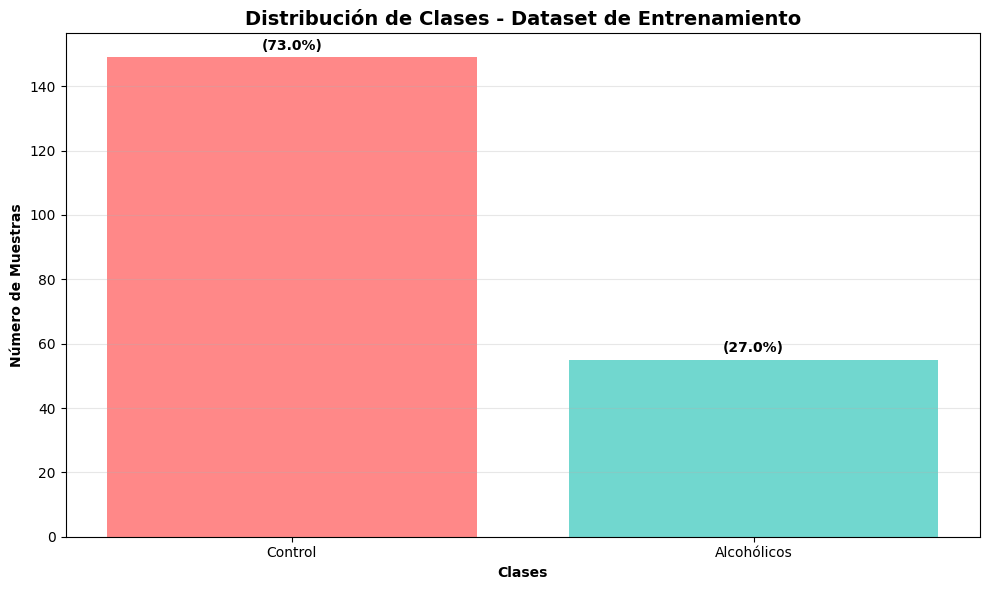

In [44]:
labels = ['Control', 'Alcohólicos']  # Clase 0: Control, Clase 1: Alcohólicos
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color=['#ff6b6b', '#4ecdc4'], alpha=0.8)
# Añadir valores en las barras
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01, 
             f'({count/len(y_train):.1%})', 
             ha='center', va='bottom', fontweight='bold')

plt.title('Distribución de Clases - Dataset de Entrenamiento', fontsize=14, fontweight='bold')
plt.ylabel('Número de Muestras', fontweight='bold')
plt.xlabel('Clases', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# Convertir a DataFrame ancho
x_h5_train_df = pd.DataFrame(X_train[:,0,:])
y_h5_train_df = pd.Series(y_train)

def parsear_times_series(dataset):
    parsed_data = []
    for id, series in enumerate(dataset):
        time_series_df = pd.DataFrame({
            'id': id,
            'time': np.arange(len(series)),
            'value': series
        })
        parsed_data.append(time_series_df)
    return pd.concat(parsed_data)

# Parsear train y test (primer canal [:,0,:])
long_train_df = parsear_times_series(X_train[:,0,:])
long_test_df = parsear_times_series(X_test[:,0,:])

y_train_series = pd.Series(y_train)

In [12]:
long_train_df.head()


,id,time,value
0,0,0,-0.005859
1,0,1,-0.011414
2,0,2,-0.010773
3,0,3,-0.010559
4,0,4,-0.008850


In [43]:
y_train_series

0      0
1      1
2      0
3      0
4      0
      ..
199    0
200    0
201    0
202    0
203    1
Length: 204, dtype: int64

In [28]:
def procesar_en_bloques(long_df, y_labels=None, bloque_size=5, dataset_name="train"):
    os.makedirs("features_chunks", exist_ok=True)
    n_ids = long_df['id'].nunique()
    chunks_files = []

    fc_parameters = MinimalFCParameters()  # features rápidas

    for start in range(0, n_ids, bloque_size):
        end = min(start + bloque_size, n_ids)
        bloque_ids = list(range(start, end))
        bloque_df = long_df[long_df['id'].isin(bloque_ids)]

        # Extraer features
        features_bloque = extract_features(
            bloque_df,
            column_id='id',
            column_sort='time',
            default_fc_parameters=fc_parameters
        )
        impute(features_bloque)
        # Guardar CSV temporal
        file_path = f"features_chunks/{dataset_name}_features_{start}_{end}.csv"
        features_bloque.to_csv(file_path)
        chunks_files.append(file_path)
        print(f"Bloque {start}-{end} procesado y guardado en {file_path}")

    # Combinar todos los CSVs
    features_final = pd.concat([pd.read_csv(f, index_col=0) for f in chunks_files])

    # Selección de features si hay etiquetas
    if y_labels is not None:
        features_final = select_features(features_final, y_labels)

    # 🔹 Guardar el archivo combinado
    final_file = f"features_chunks/{dataset_name}_features_final.csv"
    features_final.to_csv(final_file)
    print(f"Features combinadas guardadas en {final_file}")

    return features_final

In [29]:
X_train_features = procesar_en_bloques(long_train_df, y_labels=y_train_series, bloque_size=20, dataset_name="train")
X_test_features = procesar_en_bloques(long_test_df, y_labels=None, bloque_size=20, dataset_name="test")

# Alinear columnas (usar solo columnas de train en test)
X_test_features = X_test_features[X_train_features.columns]

Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 13.68it/s]


Bloque 0-20 procesado y guardado en features_chunks/train_features_0_20.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 13.67it/s]


Bloque 20-40 procesado y guardado en features_chunks/train_features_20_40.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.41it/s]


Bloque 40-60 procesado y guardado en features_chunks/train_features_40_60.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.55it/s]


Bloque 60-80 procesado y guardado en features_chunks/train_features_60_80.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.81it/s]


Bloque 80-100 procesado y guardado en features_chunks/train_features_80_100.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.18it/s]


Bloque 100-120 procesado y guardado en features_chunks/train_features_100_120.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.60it/s]


Bloque 120-140 procesado y guardado en features_chunks/train_features_120_140.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.75it/s]


Bloque 140-160 procesado y guardado en features_chunks/train_features_140_160.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.01it/s]


Bloque 160-180 procesado y guardado en features_chunks/train_features_160_180.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.63it/s]


Bloque 180-200 procesado y guardado en features_chunks/train_features_180_200.csv


Feature Extraction: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Bloque 200-204 procesado y guardado en features_chunks/train_features_200_204.csv
Features combinadas guardadas en features_chunks/train_features_final.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.42it/s]


Bloque 0-20 procesado y guardado en features_chunks/test_features_0_20.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.70it/s]


Bloque 20-40 procesado y guardado en features_chunks/test_features_20_40.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.63it/s]


Bloque 40-60 procesado y guardado en features_chunks/test_features_40_60.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 13.88it/s]


Bloque 60-80 procesado y guardado en features_chunks/test_features_60_80.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.48it/s]


Bloque 80-100 procesado y guardado en features_chunks/test_features_80_100.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.64it/s]


Bloque 100-120 procesado y guardado en features_chunks/test_features_100_120.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.33it/s]


Bloque 120-140 procesado y guardado en features_chunks/test_features_120_140.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.51it/s]


Bloque 140-160 procesado y guardado en features_chunks/test_features_140_160.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 14.22it/s]


Bloque 160-180 procesado y guardado en features_chunks/test_features_160_180.csv


Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 13.92it/s]


Bloque 180-200 procesado y guardado en features_chunks/test_features_180_200.csv


Feature Extraction: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

Bloque 200-205 procesado y guardado en features_chunks/test_features_200_205.csv
Features combinadas guardadas en features_chunks/test_features_final.csv
